In [14]:
# подключим нужные библиотеки, сразу зададим размер визуализаций

import pandahouse
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11,8)})

In [77]:
# подключимся к базе и сформируем нужный нам запрос: вытащим данные по 2 группам за период АB-теста 

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220720'
}

q = '''
    SELECT exp_group, user_id, sum(if(action = 'view', 1, 0)) as views,
            sum(if(action = 'like', 1, 0)) as likes,
            likes/views as ctr
    from simulator_20220720.feed_actions
    where toDate(time) between '2022-06-13' and '2022-06-19' and exp_group in (1, 2)
    group by exp_group, user_id
    
    '''
    
df = pandahouse.read_clickhouse(q, connection=connection)

df.head()

,exp_group,user_id,views,likes,ctr
0,1,109963,15,3,0.200000
1,1,26117,141,32,0.226950
2,1,138232,73,18,0.246575
3,1,26295,122,33,0.270492
4,1,18392,32,7,0.218750


In [78]:
# переименуем группы и подсчитаем кол-во записей по группам. Примерно равны.

df['exp_group'] = df['exp_group'].map({1 : 'control', 2 : 'test'})
df.groupby('exp_group')['ctr'].count()

exp_group
control    10079
test        9952
Name: ctr, dtype: int64

<AxesSubplot:xlabel='ctr', ylabel='Count'>

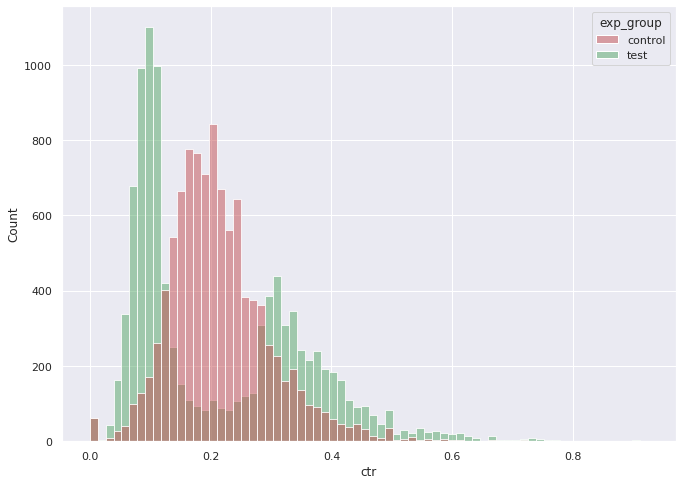

In [81]:
# Видим интересную картину. Тестовая группа стала резко ненормальной. ctr значительной части юзеров упал на ~ 10%,
# но при этом довольно большое количество юзеров стало лайкать больше. 
# Средняя контрольой группы неочевидна.

sns.histplot(df, x = df['ctr'], hue = df['exp_group'], alpha = 0.5, palette = ['r', 'g'], bins = 70)

In [82]:
# На гистограмме непонятно, какое количество юзеров имеет околонулевой ctr в тестовой группе.
# Кажется, будто в контрольной есть, а в тестовой нет. Проверим. Удостоверимся, что это не так.

zero_test = df[(df['exp_group'] == 'test') & ((df['ctr'] >= 0) & (df['ctr'] <= 0.05))]['ctr'].count()
zero_control = df[(df['exp_group'] == 'control') & ((df['ctr'] >= 0) & (df['ctr'] <= 0.05))]['ctr'].count()
print('Кол-во юзеров с сtr около нуля:  контроль:', zero_control, ', тест: ', zero_test)

Кол-во юзеров с сtr около нуля:  контроль: 91 , тест:  226


In [83]:
# показатели тестовой группы
df[df['exp_group'] == 'test']['ctr'].describe()

count    9952.000000
mean        0.214419
std         0.144180
min         0.000000
25%         0.095238
50%         0.142857
75%         0.325000
max         0.923077
Name: ctr, dtype: float64

In [84]:
# показатели контрольной группы
df[df['exp_group'] == 'control']['ctr'].describe()

count    10079.000000
mean         0.215605
std          0.084160
min          0.000000
25%          0.160097
50%          0.203125
75%          0.257654
max          0.722222
Name: ctr, dtype: float64

В итоге ещё до любых тестов имеем интересную ситуацию:
Средние групп близки, СКО у тестовой гораздо выше, медиана гораздо ниже. Только на 75 процентиле и на максимальных значениях тестовая превышает контрольную.
Новый алгоритм разделил нашу аудиторию.

Перед бустрэпом хочется провести какой-нибудь классический тест. Т-тест отметаем - тестовая точно ненормальна и дисперсии у нас различны. Посмотрим Манна-Уитни. 

In [85]:
# Н0 - средние рангов групп равны. Н1 -средний ранг тестовой  группы ниже среднего ранга контрольной.
# Итог: Есть основания  отвергнуть Н0.
stats.mannwhitneyu(df[df['exp_group'] == 'test']['ctr'],
                df[df['exp_group'] == 'control']['ctr'], alternative = 'less')

MannwhitneyuResult(statistic=43704947.5, pvalue=3.0188242308889518e-56)

In [50]:
num = 0
for _ in range(10000):
    num += df[df['exp_group'] == 'test']['ctr'].sample().values[0] > df[df['exp_group'] == 'control']['ctr'].sample().values[0]
    
print('В', num/100, '% случаев тестовая > контрольной.')

В 42.76 % случаев тестовая > контрольной.


Итак, Манна-Уитни говорит, что средние рангов неравны. Симуляция показывает, что ctr тестовых чаще ниже контрольной.
Теперь попробуем пуассоновский бутстрэп. Потому что идея гениальная.

<AxesSubplot:ylabel='Count'>

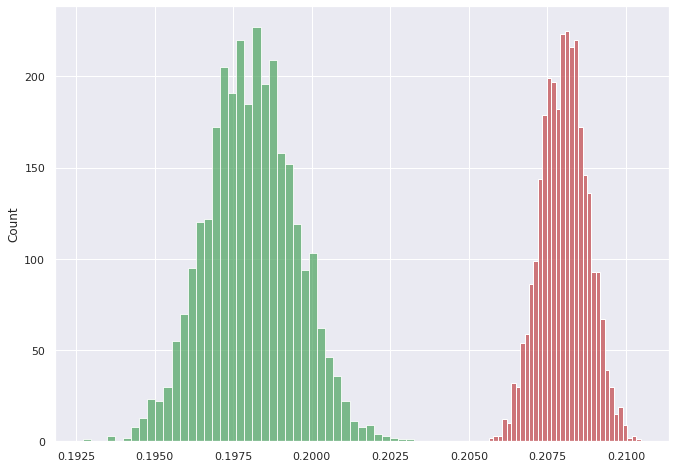

In [95]:
def poisson_bootstrap(likes1, views1, likes2, views2, n_bootstrap):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes_cont = df[df['exp_group'] == 'control']['likes'].to_numpy()
views_cont = df[df['exp_group']== 'control']['views'].to_numpy()
likes_test = df[df['exp_group'] == 'test']['likes'].to_numpy()
views_test = df[df['exp_group'] == 'test']['views'].to_numpy()

control_group, test_group = poisson_bootstrap(likes_cont, views_cont, likes_test, views_test, 3000)

sns.histplot(control_group, color = 'r')
sns.histplot(test_group, color = 'g')

Выводы:

Неодинаковость групп была видна уже на первой гистограмме и основных статистиках. Тест Манна-Уитни и пуассоновский бутстрэп подтвердили статистически значимую разницу в группах и тот факт, что ctr тестовой ниже ctr контрольной.
В задаче не указано, какой именно алгоритм мы проверяли, но очевидно, что он разделил нашу аудиторию на тех, кому новый вариант понравился и тех, кому не понравился (судим об этом по количеству лайков на просмотр), и тех, кому он не понравился, оказалось больше.
Алгоритм может быть недостаточно хорош. То есть, выдаёт не те посты, которые действительно 'сделают юзера счастливее'. Может быть, у нас не очень хорошие ml-щики, и не все необходимые признаки были учтены в модели, или же нормальной кросс-валидации не было ( раз уж они нам принесли модель, то train-test то должен был быть).
А может быть совсем другой вариант. И ctr, выбранный в качестве метрики, плохо оценивает счастье юзера от взаимодействия с постами.

В любом случае, раскатывать алгоритм на всех юзеров не будем. 